In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *
from skimage.util import montage
import pandas as pd
from torch import optim
import re
import json
from PIL import Image
import cv2
# import albumentations
from fastai.callbacks.hooks import num_features_model
from torch.nn import L1Loss

In [2]:
import numpy as np
import torch
import pandas as pd
import random
import string

In [3]:
model_name = 'efficientnet-b3'

In [4]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained(model_name) 

Loaded pretrained weights for efficientnet-b3


In [5]:
np.random.seed(42)

In [6]:
image_size = EfficientNet.get_image_size(model_name)

In [7]:
# def check_dataset_images(data_dir):
#     """
#     Some images in the dataset are corrupted or do not have any data, this method removes them
#     """
#     for i in os.listdir(data_dir):
#         for j in os.listdir(os.path.join(data_dir, i)):
#             try:
#                 img = Image.open(os.path.join(os.path.join(data_dir, i), j)) # open the image file
#                 img.verify() # verify that it is, in fact an image
#             except (IOError, SyntaxError) as e:
#                 print(j,"not real image - removing")
#                 if os.path.exists(os.path.join(os.path.join(data_dir, i), j)):
#                     os.remove(os.path.join(os.path.join(data_dir, i), j))

In [8]:
data_dir = '../../data/train/'
# check_dataset_images(data_dir)

In [9]:
src = (ImageList.from_folder(path=data_dir).split_by_rand_pct(0.2).label_from_folder())

In [10]:
res = []
res.append(rotate(degrees=(-90,90), p=1))

In [11]:
tfms=(res,[])

In [12]:
data = (src.transform(tfms, size=image_size, resize_method=ResizeMethod.SQUISH).databunch(bs=16).normalize(imagenet_stats))

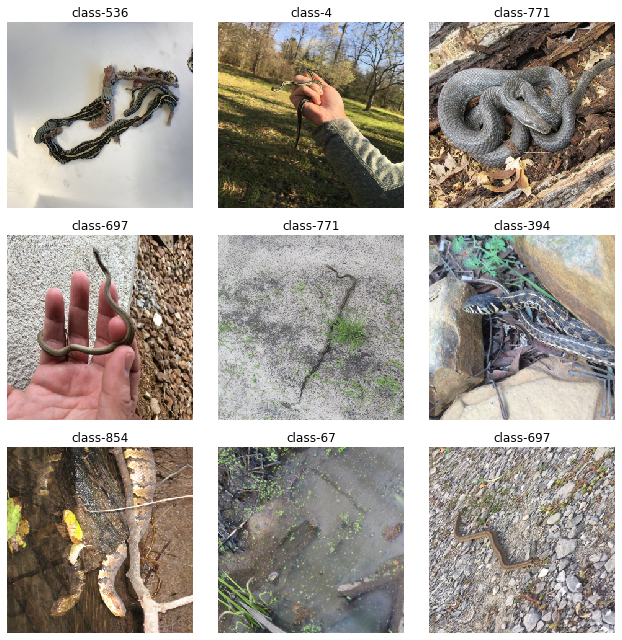

In [13]:
data.show_batch(3,figsize=(9,9))

In [14]:
list(children(model))[-2:]

[Linear(in_features=1536, out_features=1000, bias=True),
 MemoryEfficientSwish()]

In [15]:
model.add_module('_fc',nn.Linear(1536, data.c))

In [16]:
loss_func = LabelSmoothingCrossEntropy()

In [17]:
RMSprop = partial(torch.optim.RMSprop)

In [18]:
from torch.optim import Optimizer

In [19]:
learn = Learner(data, model, loss_func=loss_func, opt_func=RMSprop, metrics=[accuracy,FBeta(beta=1,average='macro')]).to_fp16()

In [20]:
learn.split([[learn.model._conv_stem, learn.model._bn0, learn.model._blocks[:8]],
             [learn.model._blocks[8:],learn.model._conv_head], 
             [learn.model._bn1,learn.model._fc]])
print("pls")

pls


In [21]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(40,max_lr=slice(lr/100,lr), callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='accuracy', name='best')])

epoch,train_loss,valid_loss,accuracy,f_beta,time


In [ ]:
save_name = model_name+"_trained_for_40"
learn.save(save_name, return_path=True)

In [ ]:
learn.fit_one_cycle(20,max_lr=slice(lr/1000,lr/100))

In [ ]:
save_name = model_name+"_trained_another_20"
learn.save(save_name, return_path=True)